In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'Right']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2448, 4) (1074, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, obs_train, shuffle=False, batch_size=X_train.shape[0], epochs=4000)

Epoch 1/4000
1/1 [==============================] - 58s 58s/step - loss: 14729.9473
Epoch 2/4000
1/1 [==============================] - 0s 37ms/step - loss: 14656.3320
Epoch 3/4000
1/1 [==============================] - 0s 29ms/step - loss: 14604.7324
Epoch 4/4000
1/1 [==============================] - 0s 19ms/step - loss: 14562.3184
Epoch 5/4000
1/1 [==============================] - 0s 19ms/step - loss: 14525.1777
Epoch 6/4000
1/1 [==============================] - 0s 18ms/step - loss: 14491.5273
Epoch 7/4000
1/1 [==============================] - 0s 19ms/step - loss: 14460.3809
Epoch 8/4000
1/1 [==============================] - 0s 18ms/step - loss: 14431.1338
Epoch 9/4000
1/1 [==============================] - 0s 18ms/step - loss: 14403.3828
Epoch 10/4000
1/1 [==============================] - 0s 18ms/step - loss: 14376.8447
Epoch 11/4000
1/1 [==============================] - 0s 16ms/step - loss: 14351.3125
Epoch 12/4000
1/1 [==============================] - 0s 18ms/step - loss: 

1/1 [==============================] - 0s 29ms/step - loss: 12960.8936
Epoch 98/4000
1/1 [==============================] - 0s 24ms/step - loss: 12949.0381
Epoch 99/4000
1/1 [==============================] - 0s 26ms/step - loss: 12937.2500
Epoch 100/4000
1/1 [==============================] - 0s 23ms/step - loss: 12925.5293
Epoch 101/4000
1/1 [==============================] - 0s 24ms/step - loss: 12913.8730
Epoch 102/4000
1/1 [==============================] - 0s 24ms/step - loss: 12902.2832
Epoch 103/4000
1/1 [==============================] - 0s 28ms/step - loss: 12890.7578
Epoch 104/4000
1/1 [==============================] - 0s 26ms/step - loss: 12879.2979
Epoch 105/4000
1/1 [==============================] - 0s 25ms/step - loss: 12867.8984
Epoch 106/4000
1/1 [==============================] - 0s 25ms/step - loss: 12856.5625
Epoch 107/4000
1/1 [==============================] - 0s 24ms/step - loss: 12845.2891
Epoch 108/4000
1/1 [==============================] - 0s 25ms/step - lo

1/1 [==============================] - 0s 24ms/step - loss: 12062.4746
Epoch 193/4000
1/1 [==============================] - 0s 24ms/step - loss: 12054.8643
Epoch 194/4000
1/1 [==============================] - 0s 23ms/step - loss: 12047.2842
Epoch 195/4000
1/1 [==============================] - 0s 23ms/step - loss: 12039.7314
Epoch 196/4000
1/1 [==============================] - 0s 23ms/step - loss: 12032.2090
Epoch 197/4000
1/1 [==============================] - 0s 23ms/step - loss: 12024.7148
Epoch 198/4000
1/1 [==============================] - 0s 24ms/step - loss: 12017.2480
Epoch 199/4000
1/1 [==============================] - 0s 24ms/step - loss: 12009.8086
Epoch 200/4000
1/1 [==============================] - 0s 23ms/step - loss: 12002.3975
Epoch 201/4000
1/1 [==============================] - 0s 23ms/step - loss: 11995.0146
Epoch 202/4000
1/1 [==============================] - 0s 24ms/step - loss: 11987.6592
Epoch 203/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 11444.0195
Epoch 288/4000
1/1 [==============================] - 0s 24ms/step - loss: 11438.4102
Epoch 289/4000
1/1 [==============================] - 0s 24ms/step - loss: 11432.8164
Epoch 290/4000
1/1 [==============================] - 0s 23ms/step - loss: 11427.2383
Epoch 291/4000
1/1 [==============================] - 0s 23ms/step - loss: 11421.6738
Epoch 292/4000
1/1 [==============================] - 0s 23ms/step - loss: 11416.1230
Epoch 293/4000
1/1 [==============================] - 0s 23ms/step - loss: 11410.5889
Epoch 294/4000
1/1 [==============================] - 0s 24ms/step - loss: 11405.0674
Epoch 295/4000
1/1 [==============================] - 0s 23ms/step - loss: 11399.5605
Epoch 296/4000
1/1 [==============================] - 0s 24ms/step - loss: 11394.0684
Epoch 297/4000
1/1 [==============================] - 0s 23ms/step - loss: 11388.5908
Epoch 298/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 10956.9922
Epoch 383/4000
1/1 [==============================] - 0s 24ms/step - loss: 10952.0791
Epoch 384/4000
1/1 [==============================] - 0s 23ms/step - loss: 10947.1689
Epoch 385/4000
1/1 [==============================] - 0s 23ms/step - loss: 10942.2607
Epoch 386/4000
1/1 [==============================] - 0s 23ms/step - loss: 10937.3545
Epoch 387/4000
1/1 [==============================] - 0s 24ms/step - loss: 10932.4492
Epoch 388/4000
1/1 [==============================] - 0s 23ms/step - loss: 10927.5449
Epoch 389/4000
1/1 [==============================] - 0s 23ms/step - loss: 10922.6406
Epoch 390/4000
1/1 [==============================] - 0s 23ms/step - loss: 10917.7363
Epoch 391/4000
1/1 [==============================] - 0s 23ms/step - loss: 10912.8320
Epoch 392/4000
1/1 [==============================] - 0s 24ms/step - loss: 10907.9268
Epoch 393/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 10396.1953
Epoch 478/4000
1/1 [==============================] - 0s 23ms/step - loss: 10389.3848
Epoch 479/4000
1/1 [==============================] - 0s 23ms/step - loss: 10382.5762
Epoch 480/4000
1/1 [==============================] - 0s 23ms/step - loss: 10375.7637
Epoch 481/4000
1/1 [==============================] - 0s 23ms/step - loss: 10368.9561
Epoch 482/4000
1/1 [==============================] - 0s 24ms/step - loss: 10362.1475
Epoch 483/4000
1/1 [==============================] - 0s 23ms/step - loss: 10355.3447
Epoch 484/4000
1/1 [==============================] - 0s 23ms/step - loss: 10348.5410
Epoch 485/4000
1/1 [==============================] - 0s 23ms/step - loss: 10341.7471
Epoch 486/4000
1/1 [==============================] - 0s 23ms/step - loss: 10334.9492
Epoch 487/4000
1/1 [==============================] - 0s 24ms/step - loss: 10328.1621
Epoch 488/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 9786.9570
Epoch 573/4000
1/1 [==============================] - 0s 28ms/step - loss: 9781.0898
Epoch 574/4000
1/1 [==============================] - 0s 24ms/step - loss: 9775.2109
Epoch 575/4000
1/1 [==============================] - 0s 25ms/step - loss: 9769.3594
Epoch 576/4000
1/1 [==============================] - 0s 24ms/step - loss: 9763.4932
Epoch 577/4000
1/1 [==============================] - 0s 24ms/step - loss: 9757.6553
Epoch 578/4000
1/1 [==============================] - 0s 24ms/step - loss: 9751.8008
Epoch 579/4000
1/1 [==============================] - 0s 24ms/step - loss: 9745.9727
Epoch 580/4000
1/1 [==============================] - 0s 24ms/step - loss: 9740.1270
Epoch 581/4000
1/1 [==============================] - 0s 24ms/step - loss: 9734.3076
Epoch 582/4000
1/1 [==============================] - 0s 24ms/step - loss: 9728.4688
Epoch 583/4000
1/1 [==============================] - 0s 23ms/step - loss: 9722.

1/1 [==============================] - 0s 23ms/step - loss: 9232.7305
Epoch 669/4000
1/1 [==============================] - 0s 24ms/step - loss: 9227.0742
Epoch 670/4000
1/1 [==============================] - 0s 23ms/step - loss: 9221.3887
Epoch 671/4000
1/1 [==============================] - 0s 23ms/step - loss: 9215.7354
Epoch 672/4000
1/1 [==============================] - 0s 23ms/step - loss: 9210.0566
Epoch 673/4000
1/1 [==============================] - 0s 24ms/step - loss: 9204.4082
Epoch 674/4000
1/1 [==============================] - 0s 24ms/step - loss: 9198.7324
Epoch 675/4000
1/1 [==============================] - 0s 24ms/step - loss: 9193.0898
Epoch 676/4000
1/1 [==============================] - 0s 23ms/step - loss: 9187.4199
Epoch 677/4000
1/1 [==============================] - 0s 23ms/step - loss: 9181.7812
Epoch 678/4000
1/1 [==============================] - 0s 24ms/step - loss: 9176.1162
Epoch 679/4000
1/1 [==============================] - 0s 23ms/step - loss: 9170.

1/1 [==============================] - 0s 24ms/step - loss: 8703.7676
Epoch 765/4000
1/1 [==============================] - 0s 28ms/step - loss: 8698.5000
Epoch 766/4000
1/1 [==============================] - 0s 26ms/step - loss: 8693.1963
Epoch 767/4000
1/1 [==============================] - 0s 61ms/step - loss: 8687.9385
Epoch 768/4000
1/1 [==============================] - 0s 26ms/step - loss: 8682.6475
Epoch 769/4000
1/1 [==============================] - 0s 23ms/step - loss: 8677.4004
Epoch 770/4000
1/1 [==============================] - 0s 25ms/step - loss: 8672.1201
Epoch 771/4000
1/1 [==============================] - 0s 24ms/step - loss: 8666.8848
Epoch 772/4000
1/1 [==============================] - 0s 25ms/step - loss: 8661.6152
Epoch 773/4000
1/1 [==============================] - 0s 23ms/step - loss: 8656.3916
Epoch 774/4000
1/1 [==============================] - 0s 23ms/step - loss: 8651.1328
Epoch 775/4000
1/1 [==============================] - 0s 23ms/step - loss: 8645.

1/1 [==============================] - 0s 24ms/step - loss: 8218.2305
Epoch 861/4000
1/1 [==============================] - 0s 25ms/step - loss: 8213.3984
Epoch 862/4000
1/1 [==============================] - 0s 24ms/step - loss: 8208.5195
Epoch 863/4000
1/1 [==============================] - 0s 24ms/step - loss: 8203.7129
Epoch 864/4000
1/1 [==============================] - 0s 23ms/step - loss: 8198.8604
Epoch 865/4000
1/1 [==============================] - 0s 24ms/step - loss: 8194.0830
Epoch 866/4000
1/1 [==============================] - 0s 23ms/step - loss: 8189.2607
Epoch 867/4000
1/1 [==============================] - 0s 23ms/step - loss: 8184.5112
Epoch 868/4000
1/1 [==============================] - 0s 24ms/step - loss: 8179.7188
Epoch 869/4000
1/1 [==============================] - 0s 23ms/step - loss: 8174.9990
Epoch 870/4000
1/1 [==============================] - 0s 23ms/step - loss: 8170.2354
Epoch 871/4000
1/1 [==============================] - 0s 22ms/step - loss: 8165.

1/1 [==============================] - 0s 25ms/step - loss: 7810.0718
Epoch 957/4000
1/1 [==============================] - 0s 24ms/step - loss: 7806.3750
Epoch 958/4000
1/1 [==============================] - 0s 24ms/step - loss: 7802.6187
Epoch 959/4000
1/1 [==============================] - 0s 24ms/step - loss: 7798.9312
Epoch 960/4000
1/1 [==============================] - 0s 24ms/step - loss: 7795.1831
Epoch 961/4000
1/1 [==============================] - 0s 24ms/step - loss: 7791.5015
Epoch 962/4000
1/1 [==============================] - 0s 24ms/step - loss: 7787.7573
Epoch 963/4000
1/1 [==============================] - 0s 24ms/step - loss: 7784.0811
Epoch 964/4000
1/1 [==============================] - 0s 24ms/step - loss: 7780.3384
Epoch 965/4000
1/1 [==============================] - 0s 23ms/step - loss: 7776.6592
Epoch 966/4000
1/1 [==============================] - 0s 25ms/step - loss: 7772.9141
Epoch 967/4000
1/1 [==============================] - 0s 23ms/step - loss: 7769.

Epoch 1052/4000
1/1 [==============================] - 0s 26ms/step - loss: 7498.1094
Epoch 1053/4000
1/1 [==============================] - 0s 37ms/step - loss: 7495.4390
Epoch 1054/4000
1/1 [==============================] - 0s 28ms/step - loss: 7492.7363
Epoch 1055/4000
1/1 [==============================] - 0s 26ms/step - loss: 7490.0840
Epoch 1056/4000
1/1 [==============================] - 0s 26ms/step - loss: 7487.3994
Epoch 1057/4000
1/1 [==============================] - 0s 24ms/step - loss: 7484.7661
Epoch 1058/4000
1/1 [==============================] - 0s 24ms/step - loss: 7482.1006
Epoch 1059/4000
1/1 [==============================] - 0s 24ms/step - loss: 7479.4863
Epoch 1060/4000
1/1 [==============================] - 0s 25ms/step - loss: 7476.8364
Epoch 1061/4000
1/1 [==============================] - 0s 25ms/step - loss: 7474.2402
Epoch 1062/4000
1/1 [==============================] - 0s 27ms/step - loss: 7471.6089
Epoch 1063/4000
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step - loss: 7277.9067
Epoch 1148/4000
1/1 [==============================] - 0s 25ms/step - loss: 7275.8833
Epoch 1149/4000
1/1 [==============================] - 0s 25ms/step - loss: 7273.9355
Epoch 1150/4000
1/1 [==============================] - 0s 24ms/step - loss: 7271.9233
Epoch 1151/4000
1/1 [==============================] - 0s 25ms/step - loss: 7269.9893
Epoch 1152/4000
1/1 [==============================] - 0s 24ms/step - loss: 7267.9893
Epoch 1153/4000
1/1 [==============================] - 0s 24ms/step - loss: 7266.0703
Epoch 1154/4000
1/1 [==============================] - 0s 25ms/step - loss: 7264.0791
Epoch 1155/4000
1/1 [==============================] - 0s 25ms/step - loss: 7262.1714
Epoch 1156/4000
1/1 [==============================] - 0s 24ms/step - loss: 7260.1953
Epoch 1157/4000
1/1 [==============================] - 0s 25ms/step - loss: 7258.3022
Epoch 1158/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 7115.7231
Epoch 1243/4000
1/1 [==============================] - 0s 23ms/step - loss: 7114.3262
Epoch 1244/4000
1/1 [==============================] - 0s 25ms/step - loss: 7112.8687
Epoch 1245/4000
1/1 [==============================] - 0s 23ms/step - loss: 7111.4917
Epoch 1246/4000
1/1 [==============================] - 0s 24ms/step - loss: 7110.0195
Epoch 1247/4000
1/1 [==============================] - 0s 23ms/step - loss: 7108.6411
Epoch 1248/4000
1/1 [==============================] - 0s 24ms/step - loss: 7107.1616
Epoch 1249/4000
1/1 [==============================] - 0s 23ms/step - loss: 7105.7959
Epoch 1250/4000
1/1 [==============================] - 0s 22ms/step - loss: 7104.3594
Epoch 1251/4000
1/1 [==============================] - 0s 22ms/step - loss: 7103.0146
Epoch 1252/4000
1/1 [==============================] - 0s 23ms/step - loss: 7101.6113
Epoch 1253/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 30ms/step - loss: 7000.0957
Epoch 1338/4000
1/1 [==============================] - 0s 30ms/step - loss: 6999.0449
Epoch 1339/4000
1/1 [==============================] - 0s 29ms/step - loss: 6998.0557
Epoch 1340/4000
1/1 [==============================] - 0s 25ms/step - loss: 6996.9927
Epoch 1341/4000
1/1 [==============================] - 0s 27ms/step - loss: 6996.0186
Epoch 1342/4000
1/1 [==============================] - 0s 25ms/step - loss: 6994.9575
Epoch 1343/4000
1/1 [==============================] - 0s 27ms/step - loss: 6993.9854
Epoch 1344/4000
1/1 [==============================] - 0s 27ms/step - loss: 6992.9634
Epoch 1345/4000
1/1 [==============================] - 0s 25ms/step - loss: 6992.0088
Epoch 1346/4000
1/1 [==============================] - 0s 27ms/step - loss: 6990.9854
Epoch 1347/4000
1/1 [==============================] - 0s 25ms/step - loss: 6990.0366
Epoch 1348/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 27ms/step - loss: 6916.0957
Epoch 1433/4000
1/1 [==============================] - 0s 29ms/step - loss: 6915.3521
Epoch 1434/4000
1/1 [==============================] - 0s 28ms/step - loss: 6914.5767
Epoch 1435/4000
1/1 [==============================] - 0s 25ms/step - loss: 6913.8506
Epoch 1436/4000
1/1 [==============================] - 0s 28ms/step - loss: 6913.0640
Epoch 1437/4000
1/1 [==============================] - 0s 25ms/step - loss: 6912.3335
Epoch 1438/4000
1/1 [==============================] - 0s 27ms/step - loss: 6911.5679
Epoch 1439/4000
1/1 [==============================] - 0s 29ms/step - loss: 6910.8809
Epoch 1440/4000
1/1 [==============================] - 0s 30ms/step - loss: 6910.0840
Epoch 1441/4000
1/1 [==============================] - 0s 25ms/step - loss: 6909.3643
Epoch 1442/4000
1/1 [==============================] - 0s 27ms/step - loss: 6908.5679
Epoch 1443/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 29ms/step - loss: 6851.9092
Epoch 1528/4000
1/1 [==============================] - 0s 29ms/step - loss: 6851.2158
Epoch 1529/4000
1/1 [==============================] - 0s 26ms/step - loss: 6850.6665
Epoch 1530/4000
1/1 [==============================] - 0s 25ms/step - loss: 6850.0210
Epoch 1531/4000
1/1 [==============================] - 0s 27ms/step - loss: 6849.4741
Epoch 1532/4000
1/1 [==============================] - 0s 24ms/step - loss: 6848.8145
Epoch 1533/4000
1/1 [==============================] - 0s 26ms/step - loss: 6848.2715
Epoch 1534/4000
1/1 [==============================] - 0s 23ms/step - loss: 6847.6450
Epoch 1535/4000
1/1 [==============================] - 0s 26ms/step - loss: 6847.1030
Epoch 1536/4000
1/1 [==============================] - 0s 25ms/step - loss: 6846.4966
Epoch 1537/4000
1/1 [==============================] - 0s 26ms/step - loss: 6845.9229
Epoch 1538/4000
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6799.4229
Epoch 1623/4000
1/1 [==============================] - 0s 25ms/step - loss: 6798.8926
Epoch 1624/4000
1/1 [==============================] - 0s 24ms/step - loss: 6798.3130
Epoch 1625/4000
1/1 [==============================] - 0s 26ms/step - loss: 6797.8145
Epoch 1626/4000
1/1 [==============================] - 0s 28ms/step - loss: 6797.3130
Epoch 1627/4000
1/1 [==============================] - 0s 26ms/step - loss: 6796.8276
Epoch 1628/4000
1/1 [==============================] - 0s 26ms/step - loss: 6796.3037
Epoch 1629/4000
1/1 [==============================] - 0s 24ms/step - loss: 6795.8047
Epoch 1630/4000
1/1 [==============================] - 0s 27ms/step - loss: 6795.4365
Epoch 1631/4000
1/1 [==============================] - 0s 24ms/step - loss: 6794.9326
Epoch 1632/4000
1/1 [==============================] - 0s 27ms/step - loss: 6794.3848
Epoch 1633/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6755.7681
Epoch 1718/4000
1/1 [==============================] - 0s 25ms/step - loss: 6755.3438
Epoch 1719/4000
1/1 [==============================] - 0s 24ms/step - loss: 6754.9746
Epoch 1720/4000
1/1 [==============================] - 0s 25ms/step - loss: 6754.5171
Epoch 1721/4000
1/1 [==============================] - 0s 25ms/step - loss: 6754.1167
Epoch 1722/4000
1/1 [==============================] - 0s 24ms/step - loss: 6753.6587
Epoch 1723/4000
1/1 [==============================] - 0s 24ms/step - loss: 6753.3979
Epoch 1724/4000
1/1 [==============================] - 0s 25ms/step - loss: 6752.7441
Epoch 1725/4000
1/1 [==============================] - 0s 26ms/step - loss: 6752.5566
Epoch 1726/4000
1/1 [==============================] - 0s 24ms/step - loss: 6752.0645
Epoch 1727/4000
1/1 [==============================] - 0s 24ms/step - loss: 6751.5166
Epoch 1728/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6719.5674
Epoch 1813/4000
1/1 [==============================] - 0s 23ms/step - loss: 6719.4570
Epoch 1814/4000
1/1 [==============================] - 0s 23ms/step - loss: 6719.5586
Epoch 1815/4000
1/1 [==============================] - 0s 23ms/step - loss: 6718.8569
Epoch 1816/4000
1/1 [==============================] - 0s 23ms/step - loss: 6718.5884
Epoch 1817/4000
1/1 [==============================] - 0s 23ms/step - loss: 6718.0225
Epoch 1818/4000
1/1 [==============================] - 0s 22ms/step - loss: 6718.0229
Epoch 1819/4000
1/1 [==============================] - 0s 23ms/step - loss: 6717.3594
Epoch 1820/4000
1/1 [==============================] - 0s 26ms/step - loss: 6717.4336
Epoch 1821/4000
1/1 [==============================] - 0s 25ms/step - loss: 6716.9976
Epoch 1822/4000
1/1 [==============================] - 0s 25ms/step - loss: 6716.1602
Epoch 1823/4000
1/1 [==============================] - 0s 48ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6689.8066
Epoch 1908/4000
1/1 [==============================] - 0s 24ms/step - loss: 6689.9092
Epoch 1909/4000
1/1 [==============================] - 0s 25ms/step - loss: 6689.3955
Epoch 1910/4000
1/1 [==============================] - 0s 26ms/step - loss: 6690.0444
Epoch 1911/4000
1/1 [==============================] - 0s 24ms/step - loss: 6689.1895
Epoch 1912/4000
1/1 [==============================] - 0s 26ms/step - loss: 6688.9238
Epoch 1913/4000
1/1 [==============================] - 0s 24ms/step - loss: 6687.9746
Epoch 1914/4000
1/1 [==============================] - 0s 24ms/step - loss: 6688.6030
Epoch 1915/4000
1/1 [==============================] - 0s 24ms/step - loss: 6688.5342
Epoch 1916/4000
1/1 [==============================] - 0s 26ms/step - loss: 6686.5479
Epoch 1917/4000
1/1 [==============================] - 0s 25ms/step - loss: 6686.7739
Epoch 1918/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6664.0767
Epoch 2003/4000
1/1 [==============================] - 0s 27ms/step - loss: 6664.9546
Epoch 2004/4000
1/1 [==============================] - 0s 25ms/step - loss: 6663.8145
Epoch 2005/4000
1/1 [==============================] - 0s 25ms/step - loss: 6664.6694
Epoch 2006/4000
1/1 [==============================] - 0s 24ms/step - loss: 6665.9941
Epoch 2007/4000
1/1 [==============================] - 0s 25ms/step - loss: 6666.2690
Epoch 2008/4000
1/1 [==============================] - 0s 24ms/step - loss: 6669.4326
Epoch 2009/4000
1/1 [==============================] - 0s 24ms/step - loss: 6668.9707
Epoch 2010/4000
1/1 [==============================] - 0s 23ms/step - loss: 6663.6953
Epoch 2011/4000
1/1 [==============================] - 0s 23ms/step - loss: 6662.7100
Epoch 2012/4000
1/1 [==============================] - 0s 23ms/step - loss: 6661.7271
Epoch 2013/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 26ms/step - loss: 6643.1753
Epoch 2098/4000
1/1 [==============================] - 0s 27ms/step - loss: 6645.7852
Epoch 2099/4000
1/1 [==============================] - 0s 23ms/step - loss: 6646.5771
Epoch 2100/4000
1/1 [==============================] - 0s 24ms/step - loss: 6644.9707
Epoch 2101/4000
1/1 [==============================] - 0s 24ms/step - loss: 6643.7432
Epoch 2102/4000
1/1 [==============================] - 0s 24ms/step - loss: 6642.3613
Epoch 2103/4000
1/1 [==============================] - 0s 24ms/step - loss: 6643.1445
Epoch 2104/4000
1/1 [==============================] - 0s 24ms/step - loss: 6641.0576
Epoch 2105/4000
1/1 [==============================] - 0s 24ms/step - loss: 6641.0752
Epoch 2106/4000
1/1 [==============================] - 0s 24ms/step - loss: 6641.8394
Epoch 2107/4000
1/1 [==============================] - 0s 24ms/step - loss: 6640.7329
Epoch 2108/4000
1/1 [==============================] - 0s 26ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6626.1523
Epoch 2193/4000
1/1 [==============================] - 0s 24ms/step - loss: 6625.2812
Epoch 2194/4000
1/1 [==============================] - 0s 23ms/step - loss: 6625.7617
Epoch 2195/4000
1/1 [==============================] - 0s 24ms/step - loss: 6625.3408
Epoch 2196/4000
1/1 [==============================] - 0s 23ms/step - loss: 6625.4053
Epoch 2197/4000
1/1 [==============================] - 0s 24ms/step - loss: 6626.4604
Epoch 2198/4000
1/1 [==============================] - 0s 24ms/step - loss: 6624.2363
Epoch 2199/4000
1/1 [==============================] - 0s 23ms/step - loss: 6623.8145
Epoch 2200/4000
1/1 [==============================] - 0s 24ms/step - loss: 6624.6113
Epoch 2201/4000
1/1 [==============================] - 0s 25ms/step - loss: 6624.0918
Epoch 2202/4000
1/1 [==============================] - 0s 24ms/step - loss: 6624.5918
Epoch 2203/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6610.1060
Epoch 2288/4000
1/1 [==============================] - 0s 24ms/step - loss: 6609.1582
Epoch 2289/4000
1/1 [==============================] - 0s 28ms/step - loss: 6609.8892
Epoch 2290/4000
1/1 [==============================] - 0s 29ms/step - loss: 6608.7876
Epoch 2291/4000
1/1 [==============================] - 0s 24ms/step - loss: 6609.2217
Epoch 2292/4000
1/1 [==============================] - 0s 29ms/step - loss: 6608.0186
Epoch 2293/4000
1/1 [==============================] - 0s 27ms/step - loss: 6608.6641
Epoch 2294/4000
1/1 [==============================] - 0s 26ms/step - loss: 6608.4707
Epoch 2295/4000
1/1 [==============================] - 0s 23ms/step - loss: 6607.6880
Epoch 2296/4000
1/1 [==============================] - 0s 24ms/step - loss: 6610.1973
Epoch 2297/4000
1/1 [==============================] - 0s 26ms/step - loss: 6610.8350
Epoch 2298/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6594.1270
Epoch 2383/4000
1/1 [==============================] - 0s 23ms/step - loss: 6595.2954
Epoch 2384/4000
1/1 [==============================] - 0s 23ms/step - loss: 6593.8496
Epoch 2385/4000
1/1 [==============================] - 0s 23ms/step - loss: 6595.0049
Epoch 2386/4000
1/1 [==============================] - 0s 22ms/step - loss: 6595.6846
Epoch 2387/4000
1/1 [==============================] - 0s 23ms/step - loss: 6595.2754
Epoch 2388/4000
1/1 [==============================] - 0s 23ms/step - loss: 6596.1797
Epoch 2389/4000
1/1 [==============================] - 0s 23ms/step - loss: 6593.9248
Epoch 2390/4000
1/1 [==============================] - 0s 22ms/step - loss: 6595.2905
Epoch 2391/4000
1/1 [==============================] - 0s 25ms/step - loss: 6592.3936
Epoch 2392/4000
1/1 [==============================] - 0s 24ms/step - loss: 6593.7104
Epoch 2393/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6579.5381
Epoch 2478/4000
1/1 [==============================] - 0s 23ms/step - loss: 6582.9170
Epoch 2479/4000
1/1 [==============================] - 0s 23ms/step - loss: 6581.2803
Epoch 2480/4000
1/1 [==============================] - 0s 23ms/step - loss: 6583.8296
Epoch 2481/4000
1/1 [==============================] - 0s 23ms/step - loss: 6586.4990
Epoch 2482/4000
1/1 [==============================] - 0s 23ms/step - loss: 6582.7383
Epoch 2483/4000
1/1 [==============================] - 0s 23ms/step - loss: 6580.8091
Epoch 2484/4000
1/1 [==============================] - 0s 25ms/step - loss: 6580.4482
Epoch 2485/4000
1/1 [==============================] - 0s 25ms/step - loss: 6577.0986
Epoch 2486/4000
1/1 [==============================] - 0s 24ms/step - loss: 6579.6797
Epoch 2487/4000
1/1 [==============================] - 0s 23ms/step - loss: 6579.9697
Epoch 2488/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6570.2090
Epoch 2573/4000
1/1 [==============================] - 0s 24ms/step - loss: 6569.3232
Epoch 2574/4000
1/1 [==============================] - 0s 24ms/step - loss: 6566.8320
Epoch 2575/4000
1/1 [==============================] - 0s 23ms/step - loss: 6565.8540
Epoch 2576/4000
1/1 [==============================] - 0s 24ms/step - loss: 6568.7266
Epoch 2577/4000
1/1 [==============================] - 0s 26ms/step - loss: 6566.0220
Epoch 2578/4000
1/1 [==============================] - 0s 25ms/step - loss: 6566.4238
Epoch 2579/4000
1/1 [==============================] - 0s 24ms/step - loss: 6567.2544
Epoch 2580/4000
1/1 [==============================] - 0s 24ms/step - loss: 6565.0791
Epoch 2581/4000
1/1 [==============================] - 0s 24ms/step - loss: 6568.6968
Epoch 2582/4000
1/1 [==============================] - 0s 24ms/step - loss: 6569.2607
Epoch 2583/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6556.5293
Epoch 2668/4000
1/1 [==============================] - 0s 23ms/step - loss: 6556.2676
Epoch 2669/4000
1/1 [==============================] - 0s 23ms/step - loss: 6558.0952
Epoch 2670/4000
1/1 [==============================] - 0s 23ms/step - loss: 6557.2705
Epoch 2671/4000
1/1 [==============================] - 0s 22ms/step - loss: 6557.2930
Epoch 2672/4000
1/1 [==============================] - 0s 23ms/step - loss: 6555.4883
Epoch 2673/4000
1/1 [==============================] - 0s 23ms/step - loss: 6557.8613
Epoch 2674/4000
1/1 [==============================] - 0s 23ms/step - loss: 6554.8818
Epoch 2675/4000
1/1 [==============================] - 0s 23ms/step - loss: 6556.8452
Epoch 2676/4000
1/1 [==============================] - 0s 23ms/step - loss: 6555.3164
Epoch 2677/4000
1/1 [==============================] - 0s 23ms/step - loss: 6553.8379
Epoch 2678/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6542.7568
Epoch 2763/4000
1/1 [==============================] - 0s 23ms/step - loss: 6543.0669
Epoch 2764/4000
1/1 [==============================] - 0s 23ms/step - loss: 6542.4556
Epoch 2765/4000
1/1 [==============================] - 0s 23ms/step - loss: 6541.4629
Epoch 2766/4000
1/1 [==============================] - 0s 24ms/step - loss: 6542.9185
Epoch 2767/4000
1/1 [==============================] - 0s 23ms/step - loss: 6542.7500
Epoch 2768/4000
1/1 [==============================] - 0s 23ms/step - loss: 6545.2886
Epoch 2769/4000
1/1 [==============================] - 0s 24ms/step - loss: 6548.4336
Epoch 2770/4000
1/1 [==============================] - 0s 23ms/step - loss: 6547.1777
Epoch 2771/4000
1/1 [==============================] - 0s 23ms/step - loss: 6545.1460
Epoch 2772/4000
1/1 [==============================] - 0s 23ms/step - loss: 6543.7168
Epoch 2773/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6533.1484
Epoch 2858/4000
1/1 [==============================] - 0s 23ms/step - loss: 6536.6836
Epoch 2859/4000
1/1 [==============================] - 0s 23ms/step - loss: 6532.6401
Epoch 2860/4000
1/1 [==============================] - 0s 23ms/step - loss: 6533.2935
Epoch 2861/4000
1/1 [==============================] - 0s 23ms/step - loss: 6534.0806
Epoch 2862/4000
1/1 [==============================] - 0s 22ms/step - loss: 6532.7690
Epoch 2863/4000
1/1 [==============================] - 0s 23ms/step - loss: 6534.1611
Epoch 2864/4000
1/1 [==============================] - 0s 23ms/step - loss: 6541.8018
Epoch 2865/4000
1/1 [==============================] - 0s 23ms/step - loss: 6543.3545
Epoch 2866/4000
1/1 [==============================] - 0s 23ms/step - loss: 6542.7559
Epoch 2867/4000
1/1 [==============================] - 0s 23ms/step - loss: 6535.5493
Epoch 2868/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6524.2754
Epoch 2953/4000
1/1 [==============================] - 0s 23ms/step - loss: 6528.5762
Epoch 2954/4000
1/1 [==============================] - 0s 23ms/step - loss: 6529.9395
Epoch 2955/4000
1/1 [==============================] - 0s 23ms/step - loss: 6525.9741
Epoch 2956/4000
1/1 [==============================] - 0s 23ms/step - loss: 6522.3438
Epoch 2957/4000
1/1 [==============================] - 0s 23ms/step - loss: 6522.4175
Epoch 2958/4000
1/1 [==============================] - 0s 23ms/step - loss: 6522.1270
Epoch 2959/4000
1/1 [==============================] - 0s 23ms/step - loss: 6521.1665
Epoch 2960/4000
1/1 [==============================] - 0s 23ms/step - loss: 6523.6919
Epoch 2961/4000
1/1 [==============================] - 0s 22ms/step - loss: 6523.6621
Epoch 2962/4000
1/1 [==============================] - 0s 23ms/step - loss: 6523.6455
Epoch 2963/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6511.9756
Epoch 3048/4000
1/1 [==============================] - 0s 26ms/step - loss: 6510.6401
Epoch 3049/4000
1/1 [==============================] - 0s 25ms/step - loss: 6516.5322
Epoch 3050/4000
1/1 [==============================] - 0s 23ms/step - loss: 6511.5195
Epoch 3051/4000
1/1 [==============================] - 0s 23ms/step - loss: 6512.4092
Epoch 3052/4000
1/1 [==============================] - 0s 24ms/step - loss: 6510.0205
Epoch 3053/4000
1/1 [==============================] - 0s 23ms/step - loss: 6511.4248
Epoch 3054/4000
1/1 [==============================] - 0s 23ms/step - loss: 6511.7432
Epoch 3055/4000
1/1 [==============================] - 0s 23ms/step - loss: 6513.5518
Epoch 3056/4000
1/1 [==============================] - 0s 24ms/step - loss: 6518.5371
Epoch 3057/4000
1/1 [==============================] - 0s 24ms/step - loss: 6517.4678
Epoch 3058/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6502.4604
Epoch 3143/4000
1/1 [==============================] - 0s 23ms/step - loss: 6505.3501
Epoch 3144/4000
1/1 [==============================] - 0s 22ms/step - loss: 6503.9873
Epoch 3145/4000
1/1 [==============================] - 0s 23ms/step - loss: 6504.9502
Epoch 3146/4000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 3147/4000
1/1 [==============================] - 0s 23ms/step - loss: 6507.1987
Epoch 3148/4000
1/1 [==============================] - 0s 22ms/step - loss: 6503.4453
Epoch 3149/4000
1/1 [==============================] - 0s 23ms/step - loss: 6502.9785
Epoch 3150/4000
1/1 [==============================] - 0s 23ms/step - loss: 6502.8208
Epoch 3151/4000
1/1 [==============================] - 0s 22ms/step - loss: 6501.7676
Epoch 3152/4000
1/1 [==============================] - 0s 23ms/step - loss: 6504.7480
Epoch 3153/4000
1/1 [==============================] - 0s 23ms/step - loss: 

1/1 [==============================] - 0s 23ms/step - loss: 6494.9746
Epoch 3238/4000
1/1 [==============================] - 0s 26ms/step - loss: 6493.8691
Epoch 3239/4000
1/1 [==============================] - 0s 24ms/step - loss: 6499.4312
Epoch 3240/4000
1/1 [==============================] - 0s 23ms/step - loss: 6496.3306
Epoch 3241/4000
1/1 [==============================] - 0s 23ms/step - loss: 6497.9004
Epoch 3242/4000
1/1 [==============================] - 0s 23ms/step - loss: 6497.9902
Epoch 3243/4000
1/1 [==============================] - 0s 23ms/step - loss: 6498.8818
Epoch 3244/4000
1/1 [==============================] - 0s 23ms/step - loss: 6498.9482
Epoch 3245/4000
1/1 [==============================] - 0s 23ms/step - loss: 6496.5503
Epoch 3246/4000
1/1 [==============================] - 0s 23ms/step - loss: 6495.4458
Epoch 3247/4000
1/1 [==============================] - 0s 23ms/step - loss: 6495.7007
Epoch 3248/4000
1/1 [==============================] - 0s 22ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6486.0098
Epoch 3333/4000
1/1 [==============================] - 0s 23ms/step - loss: 6486.9253
Epoch 3334/4000
1/1 [==============================] - 0s 22ms/step - loss: 6488.9751
Epoch 3335/4000
1/1 [==============================] - 0s 22ms/step - loss: 6488.0430
Epoch 3336/4000
1/1 [==============================] - 0s 23ms/step - loss: 6487.4023
Epoch 3337/4000
1/1 [==============================] - 0s 23ms/step - loss: 6487.0107
Epoch 3338/4000
1/1 [==============================] - 0s 22ms/step - loss: 6488.2344
Epoch 3339/4000
1/1 [==============================] - 0s 25ms/step - loss: 6487.1621
Epoch 3340/4000
1/1 [==============================] - 0s 23ms/step - loss: 6486.1963
Epoch 3341/4000
1/1 [==============================] - 0s 23ms/step - loss: 6490.3765
Epoch 3342/4000
1/1 [==============================] - 0s 23ms/step - loss: 6487.8052
Epoch 3343/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 22ms/step - loss: 6482.8979
Epoch 3428/4000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 3429/4000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 3430/4000
1/1 [==============================] - 0s 24ms/step - loss: 6488.2266
Epoch 3431/4000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 3432/4000
1/1 [==============================] - 0s 25ms/step - loss: 6482.3066
Epoch 3433/4000
1/1 [==============================] - 0s 25ms/step - loss: nan
Epoch 3434/4000
1/1 [==============================] - 0s 25ms/step - loss: 6482.1602
Epoch 3435/4000
1/1 [==============================] - 0s 25ms/step - loss: nan
Epoch 3436/4000
1/1 [==============================] - 0s 24ms/step - loss: 6484.6445
Epoch 3437/4000
1/1 [==============================] - 0s 24ms/step - loss: nan
Epoch 3438/4000
1/1 [==============================] - 0s 24ms/step - loss: 6480.5957
Epoch 3439/4000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 6475.5811
Epoch 3524/4000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 3525/4000
1/1 [==============================] - 0s 22ms/step - loss: 6476.5674
Epoch 3526/4000
1/1 [==============================] - 0s 24ms/step - loss: 6477.3027
Epoch 3527/4000
1/1 [==============================] - 0s 23ms/step - loss: 6477.9355
Epoch 3528/4000
1/1 [==============================] - 0s 23ms/step - loss: 6477.7627
Epoch 3529/4000
1/1 [==============================] - 0s 23ms/step - loss: 6480.0586
Epoch 3530/4000
1/1 [==============================] - 0s 23ms/step - loss: 6480.1680
Epoch 3531/4000
1/1 [==============================] - 0s 23ms/step - loss: 6480.6411
Epoch 3532/4000
1/1 [==============================] - 0s 22ms/step - loss: 6482.4111
Epoch 3533/4000
1/1 [==============================] - 0s 23ms/step - loss: 6477.5571
Epoch 3534/4000
1/1 [==============================] - 0s 23ms/step - loss: 

1/1 [==============================] - 0s 23ms/step - loss: 6471.4556
Epoch 3619/4000
1/1 [==============================] - 0s 22ms/step - loss: 6471.3164
Epoch 3620/4000
1/1 [==============================] - 0s 22ms/step - loss: 6471.7822
Epoch 3621/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.2266
Epoch 3622/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.2061
Epoch 3623/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.7041
Epoch 3624/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.2793
Epoch 3625/4000
1/1 [==============================] - 0s 23ms/step - loss: 6470.9097
Epoch 3626/4000
1/1 [==============================] - 0s 23ms/step - loss: 6473.5664
Epoch 3627/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.8809
Epoch 3628/4000
1/1 [==============================] - 0s 22ms/step - loss: 6471.7002
Epoch 3629/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6472.2827
Epoch 3714/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.1797
Epoch 3715/4000
1/1 [==============================] - 0s 23ms/step - loss: 6470.0884
Epoch 3716/4000
1/1 [==============================] - 0s 23ms/step - loss: 6469.5332
Epoch 3717/4000
1/1 [==============================] - 0s 22ms/step - loss: 6468.8877
Epoch 3718/4000
1/1 [==============================] - 0s 22ms/step - loss: 6466.5088
Epoch 3719/4000
1/1 [==============================] - 0s 23ms/step - loss: 6467.8184
Epoch 3720/4000
1/1 [==============================] - 0s 22ms/step - loss: 6466.1455
Epoch 3721/4000
1/1 [==============================] - 0s 22ms/step - loss: 6469.0034
Epoch 3722/4000
1/1 [==============================] - 0s 23ms/step - loss: 6467.9199
Epoch 3723/4000
1/1 [==============================] - 0s 23ms/step - loss: 6468.1709
Epoch 3724/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6464.1694
Epoch 3809/4000
1/1 [==============================] - 0s 23ms/step - loss: 6465.8501
Epoch 3810/4000
1/1 [==============================] - 0s 23ms/step - loss: 6463.0684
Epoch 3811/4000
1/1 [==============================] - 0s 23ms/step - loss: 6466.6089
Epoch 3812/4000
1/1 [==============================] - 0s 23ms/step - loss: 6462.7090
Epoch 3813/4000
1/1 [==============================] - 0s 23ms/step - loss: 6462.2725
Epoch 3814/4000
1/1 [==============================] - 0s 23ms/step - loss: 6461.7363
Epoch 3815/4000
1/1 [==============================] - 0s 24ms/step - loss: 6466.0371
Epoch 3816/4000
1/1 [==============================] - 0s 25ms/step - loss: 6464.9277
Epoch 3817/4000
1/1 [==============================] - 0s 23ms/step - loss: 6462.7480
Epoch 3818/4000
1/1 [==============================] - 0s 23ms/step - loss: 6461.8247
Epoch 3819/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6458.3564
Epoch 3904/4000
1/1 [==============================] - 0s 24ms/step - loss: 6457.8530
Epoch 3905/4000
1/1 [==============================] - 0s 23ms/step - loss: 6458.0903
Epoch 3906/4000
1/1 [==============================] - 0s 24ms/step - loss: 6459.0586
Epoch 3907/4000
1/1 [==============================] - 0s 25ms/step - loss: 6459.8535
Epoch 3908/4000
1/1 [==============================] - 0s 24ms/step - loss: 6457.2900
Epoch 3909/4000
1/1 [==============================] - 0s 25ms/step - loss: 6456.3291
Epoch 3910/4000
1/1 [==============================] - 0s 43ms/step - loss: 6458.3350
Epoch 3911/4000
1/1 [==============================] - 0s 24ms/step - loss: 6460.9639
Epoch 3912/4000
1/1 [==============================] - 0s 28ms/step - loss: 6458.2627
Epoch 3913/4000
1/1 [==============================] - 0s 23ms/step - loss: 6458.3394
Epoch 3914/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6456.8711
Epoch 3999/4000
1/1 [==============================] - 0s 24ms/step - loss: 6456.3232
Epoch 4000/4000
1/1 [==============================] - 0s 23ms/step - loss: 6456.1528


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

34/34 [==============================] - 0s 372us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['val1'].append(ts_df.item_value_1[s])
        pred_bhv['val2'].append(ts_df.item_value_2[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

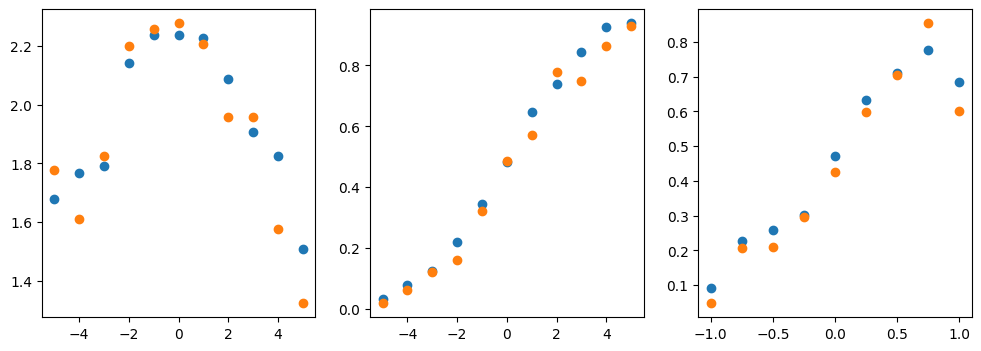

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1);

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1);

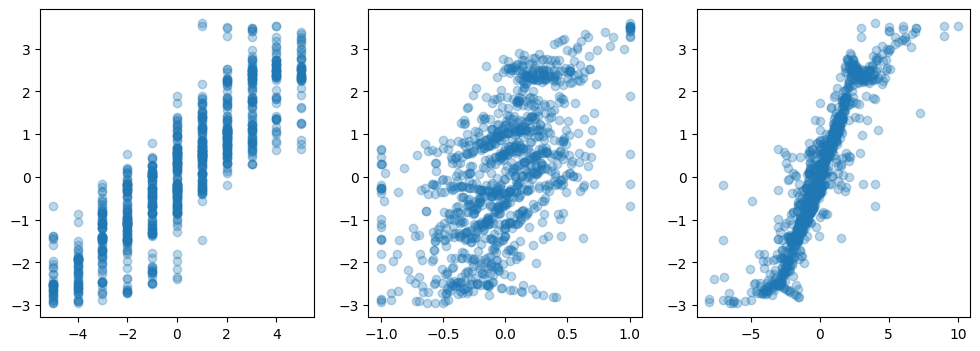

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);